In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

from tqdm import tqdm

import scanpy as sc

from causarray import *

import os
path_result = 'results/LUHMES/'
os.makedirs(path_result, exist_ok=True)

# Data

In [2]:
from sklearn.preprocessing import OneHotEncoder
import h5py

with h5py.File('data/LUHMES/LUHMES.h5', 'r') as f:
    print(f.keys())
    counts = np.array(f['counts'], dtype='float')
    sgRNA = np.array(f['sgRNA'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    cell_ids = np.array(f['cell_ids'], dtype='S32').astype(str)
    covariates = pd.DataFrame(np.array(f['covariates'])).astype(float).values
    pt_state = covariates[:,-1]
    
    covariates = np.c_[np.ones(covariates.shape[0]), np.log(np.sum(counts, axis=1)),  covariates]    

    id_cell = (~np.char.startswith(sgRNA, 'RELN')) & (pt_state>3)
    counts = counts[id_cell] 
    sgRNA = sgRNA[id_cell]
    cell_ids = cell_ids[id_cell]
    covariates = covariates[id_cell]
    pt_state = pt_state[id_cell]

    covariates = np.c_[
        covariates[:,:-2],
        OneHotEncoder(drop='first', sparse_output=False).fit_transform(covariates[:,-2:])
    ]

    print(counts.shape, sgRNA.shape, cell_ids.shape, covariates.shape)

gRNA_names = ["PTEN","CHD2","ASH1L","ADNP"]    

<KeysViewHDF5 ['cell_ids', 'counts', 'covariates', 'gene_names', 'sgRNA']>


(4881, 1944) (4881,) (4881,) (4881, 8)


# Visualization

In [3]:
gRNA_name = gRNA_names[0]

id_cells = ((np.char.startswith(sgRNA, gRNA_name) | np.char.startswith(sgRNA, 'Nontargeting')))

Y = counts[id_cells]
A = np.char.startswith(sgRNA[id_cells], gRNA_name)
W = covariates[id_cells]
W = W / np.sqrt(np.sum(W**2, 0, keepdims=True)) * np.sqrt(W.shape[0])

id_genes = np.any(Y!=0, axis=0) & (np.sum(Y>0, axis=0)>=50)
Y = Y[:,id_genes]
print(
    gRNA_name, 
    len(id_genes), 
    Y.shape, A.shape, np.sum(A), W.shape)


PTEN 1944 (1014, 1444) (1014,) 458 (1014, 8)


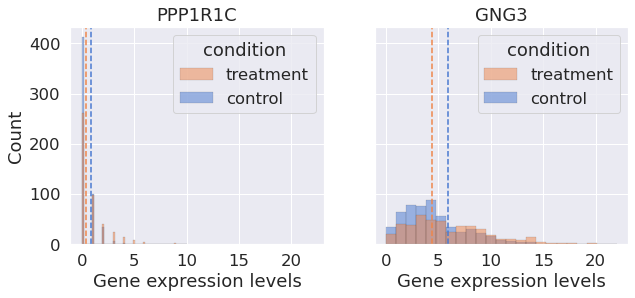

In [4]:
colors = [sns.color_palette("muted")[1], sns.color_palette("muted")[0]]
sns.set(font_scale=1.5)
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey='row', sharex = True)

for i,name in enumerate(['PPP1R1C','GNG3']):
    j = np.where(gene_names[id_genes]==name)[0][0]
    axes[i] = sns.histplot(pd.DataFrame({'x':Y[:,j], 'condition':np.where(A==1, 'treatment', 'control')}), 
        x = 'x', hue = 'condition', hue_order=['treatment', 'control'],
        palette=colors, linewidth=0.1, edgecolor='k', ax=axes[i])
    
    for k in range(2):
        axes[i].axvline(np.mean(Y[A==k,j]), color=colors[k], linestyle='--')
    axes[i].set_title(gene_names[id_genes][j])

    axes[i].set_xlabel('Gene expression levels')

plt.savefig(path_result + 'LUHMES_gene_expression_levels.pdf', bbox_inches='tight')

# Doubly robust estimation and inference

In [5]:
for gRNA_name in gRNA_names:

    id_cells = (np.char.startswith(sgRNA, gRNA_name) | np.char.startswith(sgRNA, 'Nontargeting'))

    Y = counts[id_cells]
    A = np.char.startswith(sgRNA[id_cells], gRNA_name)
    W = covariates[id_cells]
    W = W / np.sqrt(np.sum(W**2, 0, keepdims=True)) * np.sqrt(W.shape[0])

    id_genes = np.any(Y!=0, axis=0) & (np.sum(Y>0, axis=0)>=50)
    Y = Y[:,id_genes]
    print(gRNA_name, len(id_genes), Y.shape, A.shape, np.sum(A), W.shape)

    # record covariate adjusted residual for plotting later
    if gRNA_name == 'PTEN':
        df_glm_p, df_glm_nb = glm_test(Y, W, A[:,None])
        resid = fit_glm(Y, W, np.zeros((Y.shape[0],0)), family='nb')[-1]

    for func in [ATE, SATE]:
        df = func(Y, W, A, B=10000, alpha=0.05, c=0.01, family='nb')
        df.to_csv(path_result+'{}_{}.csv'.format(gRNA_name, func.__name__), index=False)
    

PTEN 1944 (1014, 1444) (1014,) 458 (1014, 8)


CHD2 1944 (756, 1360) (756,) 200 (756, 8)
ASH1L 1944 (725, 1360) (725,) 169 (725, 8)
ADNP 1944 (895, 1416) (895,) 339 (895, 8)


# Residual plots

In [6]:
gRNA_name = 'PTEN'
id_cells = (np.char.startswith(sgRNA, gRNA_name) | np.char.startswith(sgRNA, 'Nontargeting'))

Y = counts[id_cells]
A = np.char.startswith(sgRNA[id_cells], gRNA_name)
W = covariates[id_cells]
W = W / np.sqrt(np.sum(W**2, 0, keepdims=True)) * np.sqrt(W.shape[0])

id_genes = np.any(Y!=0, axis=0) & (np.sum(Y>0, axis=0)>=50)
Y = Y[:,id_genes]

df_ATE = pd.read_csv(path_result+'{}_ATE.csv'.format(gRNA_name))
df_STE = pd.read_csv(path_result+'{}_SATE.csv'.format(gRNA_name))

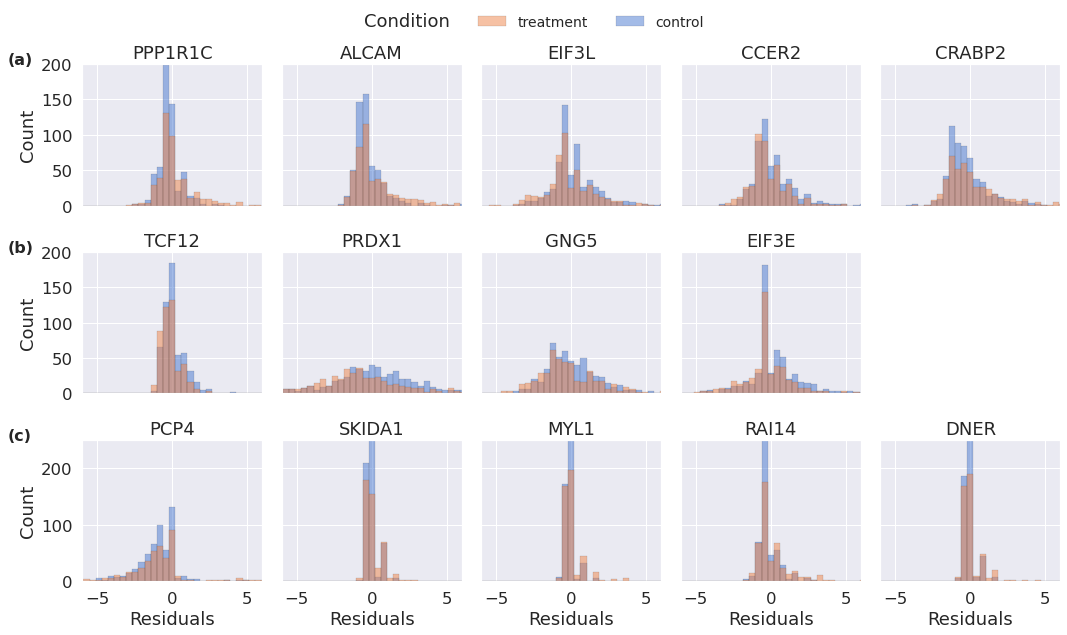

In [7]:
n_col = 5
colors = [sns.color_palette("muted")[1], sns.color_palette("muted")[0]]
sns.set(font_scale=1.5)
fig, axes = plt.subplots(3, n_col, figsize=(15,9), sharey='row', sharex=True)

idx = np.where((df_ATE['rej']==1)&(df_STE['rej']==1))[0]
for ij in range(n_col):
    j = idx[np.argsort(np.abs(df_STE['tvalues_init'].values)[idx])[ij]]
    axes[0,ij] = sns.histplot(pd.DataFrame({'x':resid[:,j], 'condition':np.where(A==1, 'treatment', 'control')}), 
        x = 'x', hue = 'condition', hue_order=['treatment', 'control'], bins=np.linspace(-10,10,50),
        palette=colors, linewidth=0.1, edgecolor='k', ax=axes[0,ij])
    axes[0,ij].set_title(gene_names[id_genes][j])

i = 2
idx = np.where((df_ATE['rej']==1)&(df_STE['rej']==0))[0]
for ij in range(n_col):
    j = idx[np.argsort(np.abs(df_STE['tvalues_init'].values)[idx])[ij]]
    axes[i,ij] = sns.histplot(pd.DataFrame({'x':resid[:,j], 'condition':np.where(A==1, 'treatment', 'control')}), 
        x = 'x', hue = 'condition', hue_order=['treatment', 'control'], bins=np.linspace(-10,10,50),
        palette=colors, linewidth=0.1, edgecolor='k', ax=axes[i,ij])
    axes[i,ij].set_title(gene_names[id_genes][j])

i = 1
idx = np.where((df_ATE['rej']==0)&(df_STE['rej']==1))[0]
for ij in range(n_col):
    if ij>=len(idx):
        fig.delaxes(axes[i,ij])
        continue
    j = idx[np.argsort(np.abs(df_STE['tvalues_init'].values)[idx])[ij]]
    axes[i,ij] = sns.histplot(pd.DataFrame({'x':resid[:,j], 'condition':np.where(A==1, 'treatment', 'control')}), 
        x = 'x', hue = 'condition', hue_order=['treatment', 'control'], bins=np.linspace(-10,10,50),
        palette=colors, linewidth=0.1, edgecolor='k', ax=axes[i,ij])
    axes[i,ij].set_title(gene_names[id_genes][j])


legend = axes[0,0].get_legend(); handles = legend.legendHandles
labels = [t.get_text() for t in legend.get_texts()]
for i in range(3):
    axes[i,-1].set_xlim([-6,6])    
    for j in range(n_col):
        try:
            axes[i,j].get_legend().remove()
        except:
            pass
        if i==2:
            axes[i,j].set_xlabel('Residuals')

axes[0,0].set_ylim([0,200])
axes[1,0].set_ylim([0,200])
axes[2,0].set_ylim([0,250])

legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=10, title='Condition', frameon=False, fontsize=14)
def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

axes[0,0].text(axes[0,0].get_xlim()[0]-5, axes[0,0].get_ylim()[1], '(a)', fontsize=16, weight='bold')
axes[1,0].text(axes[1,0].get_xlim()[0]-5, axes[1,0].get_ylim()[1], '(b)', fontsize=16, weight='bold')
axes[2,0].text(axes[2,0].get_xlim()[0]-5, axes[2,0].get_ylim()[1], '(c)', fontsize=16, weight='bold')


fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig('figures/LUHMES_{}_residuals.pdf'.format(gRNA_name), bbox_inches='tight', pad_inches=0, dpi=300)

# Summarized statistics

In [8]:
import scipy as sp
def summarize(Y, resid, A):
    res_diff = np.r_[
        np.abs(np.mean(resid[A==1]) - np.mean(resid[A==0]))/2,
        np.abs(np.mean((resid+Y)[A==1]) - np.mean((resid+Y)[A==0]))/np.std((resid+Y)[A==0]),
        np.abs(np.median((resid+Y)[A==1]) - np.median((resid+Y)[A==0]))/np.std((resid+Y)[A==0])
    ]

    res_overall = np.r_[
        np.mean(Y==0),         
    ]

    res = np.r_[res_diff, res_overall]
    return res
    
idx_list = [
    np.where((df_ATE['rej']==1)&(df_STE['rej']==1))[0],    
    np.where((df_ATE['rej']==0)&(df_STE['rej']==1))[0],
    np.where((df_ATE['rej']==1)&(df_STE['rej']==0))[0],

]

res_all = []
for i, idx in enumerate(idx_list):
    for j in idx:
        res = np.r_[summarize(Y[:,j], resid[:,j], A), j, i]
        
        res_all.append(res)
res_all = np.array(res_all)

In [9]:
col_names = ['Absolute difference\nof residual mean',
    'Absolute difference\nof fitted response mean',
    'Absolute difference\nof fitted response median',
    'Proportion of\nzero counts', 'j', 'Test']
_df = pd.DataFrame(res_all, columns=col_names)
_df['Test'] = _df['Test'].map(
    {0: 'Common ({})'.format(np.sum(_df['Test']==0)), 1: 'STE only ({})'.format(np.sum(_df['Test']==1)), 
    2: 'ATE only ({})'.format(np.sum(_df['Test']==2))})
_df['count'] = _df.groupby('Test')['Test'].transform('count')

_df.to_csv(path_result+'{}_summary.csv'.format(gRNA_name), index=False)

print(_df.groupby('Test').median())
_df = _df.melt(id_vars=['j', 'Test'], value_vars=col_names[:-2], value_name='Value', var_name='Metric')


               Absolute difference\nof residual mean  \
Test                                                   
ATE only (10)                               0.137157   
Common (22)                                 0.307546   
STE only (4)                                0.231693   

               Absolute difference\nof fitted response mean  \
Test                                                          
ATE only (10)                                      0.436272   
Common (22)                                        0.250622   
STE only (4)                                       0.151403   

               Absolute difference\nof fitted response median  \
Test                                                            
ATE only (10)                                        0.032957   
Common (22)                                          0.153083   
STE only (4)                                         0.152631   

               Proportion of\nzero counts      j  count  
Test               

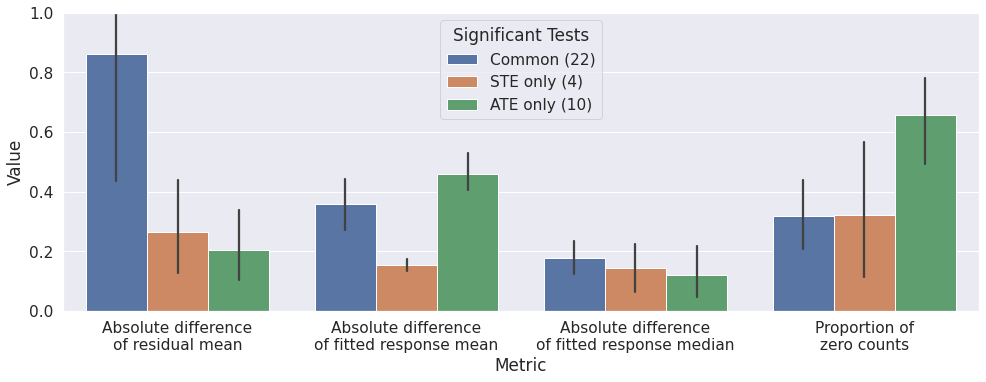

In [10]:
sns.set(font_scale=1.4)
fig, ax = plt.subplots(1, 1, figsize=(14,6))

sns.barplot(_df, y='Value', x='Metric', hue='Test', ax=ax)
plt.ylim([0,1])

ax.legend(title='Significant Tests')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('figures/LUHMES_{}_metric.pdf'.format(gRNA_name), bbox_inches='tight', pad_inches=0, dpi=300)

# Discoveries on all gRNAs

In [11]:
df_sig = []
for gRNA_name in gRNA_names:    
    id_cells = (np.char.startswith(sgRNA, gRNA_name) | np.char.startswith(sgRNA, 'Nontargeting'))

    Y = counts[id_cells]
    A = np.char.startswith(sgRNA[id_cells], gRNA_name)
    W = covariates[id_cells]
    W = W / np.sqrt(np.sum(W**2, 0, keepdims=True)) * np.sqrt(W.shape[0])

    id_genes = np.any(Y!=0, axis=0) & (np.sum(Y>0, axis=0)>=50)

    _df_ATE = pd.read_csv(path_result+'{}_ATE.csv'.format(gRNA_name))
    _df_STE = pd.read_csv(path_result+'{}_SATE.csv'.format(gRNA_name))

    df_sig.append(
        [gRNA_name,
        ', '.join(gene_names[id_genes][(_df_ATE['rej']==1)&(_df_STE['rej']==1)]),
        ', '.join(gene_names[id_genes][(_df_ATE['rej']==1)&(_df_STE['rej']==0)]),
        ', '.join(gene_names[id_genes][(_df_ATE['rej']==0)&(_df_STE['rej']==1)]),
    ])

df_sig = pd.DataFrame(df_sig, columns=['gRNA', 'Common', 'ATE', 'STE'])

In [12]:
print(df_sig.to_latex(index=False))

\begin{tabular}{llll}
\toprule
gRNA & Common & ATE & STE \\
\midrule
PTEN & PTH2, PTGDS, NEFM, EEF1A1, C21orf59, MFAP4, ALCAM, NEFL, ITM2C, CRABP2, SLC25A6, EIF3L, WLS, PPP1R1C, CCER2, GNB2L1, SVIP, RGS10, H3F3A, DRAXIN, TCP10L, EIF3K & PCP4, MYL1, RAI14, DNER, MAP7, SNCA, TSC22D1, NRP2, GNG3, SKIDA1 & EIF3E, PRDX1, GNG5, TCF12 \\
CHD2 & MLLT11, EEF1A1, MARCKSL1, NEFL, HN1, GNG3, ID4, EEF2, STMN2 & PRDX1, TUBB4B & PCP4, CALY \\
ASH1L & MT-CO1, MT-CYB, FXYD7 & MT-ND1 & PKP4 \\
ADNP & C21orf59, MAP1B & MEG3, PTGDS, LHX2 & NEFM, RTN1, C1orf54 \\
\bottomrule
\end{tabular}

